# Exercise 1 - 3D - 2D

In [1]:
import cv2 as cv2
import numpy as np

Recall from the slides the steps from Algorithm 3:

![title](algorithm_3.png)

![title](PnP.png)

# Exercise 1a)
The steps 1)-2.1) has already been done, and is saved in corresponding files. The exercise is to implement step 2.2) by filling in the missing code below

In [14]:
def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCV to find the prev_points from the prev_img in the next_img
    Remember to remove points that could not be found from prev_points, next_points, and world_points
    hint: status == 1
    """
    params = dict(winSize=(21, 21),
                  maxLevel=3,
                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Calculate optical flow to track prev_points in the next_img
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points,
                                                      None, **params)

    valid_idx = np.where(status.ravel() == 1)[0]  # Indices of successfully tracked points

    return world_points[valid_idx], prev_points[valid_idx], next_points[valid_idx]

Hint: Exercise 4 in week 2

# Exercise 1b)
Continue the algorithm by implementing step 2.3)

In [44]:
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02],  # camera matrix
              [0, 7.188560e+02, 1.852157e+02],
              [0, 0, 1]])

reference_img = np.load("img_" + str(0) + ".npy")

tvec_list = np.zeros((6, 6))

for t in range(1, 6):
    # the image at current time=t
    curImage = np.load("img_" + str(t) + ".npy")
    # the 3D landmarks in the world coordinates which have been computed in time=t-1
    landmark_3D = np.load("landmark_" + str(t - 1) + ".npy")
    # the 2D coordinates of the 3D points in the previous frame at time=t-1
    reference_2D = np.load("reference_2D_" + str(t - 1) + ".npy")

    # the 2D landmarks at the current time = t
    landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(reference_img,
                                                                  curImage,
                                                                  reference_2D,
                                                                  landmark_3D)

    """
    Using OpenCV, implement PnP using Ransac
    """
    success, rvec, tvec, inliers = cv2.solvePnPRansac(landmark_3D, tracked_2Dpoints, K, np.zeros((4, 1)))

    """
    Transform the translation and rotation into the world frame
    """
    R, _ = cv2.Rodrigues(rvec)
    tvec = - R @ tvec

    print(tvec[0], tvec[1], tvec[2], rvec[0], rvec[1], rvec[2])
    tvec_list[t, :3] = tvec.squeeze()
    tvec_list[t, 3:] = rvec.squeeze()

    # update for next timestep
    reference_img = curImage

[-0.00110257] [-0.00067197] [-0.00078349] [-7.40069215e-05] [-7.35119066e-05] [9.84544281e-05]
[0.00072938] [-0.00581528] [0.67584941] [-0.00216658] [0.00325854] [-0.00244333]
[0.0097181] [-0.00631061] [1.37750075] [-0.00364614] [0.00751509] [-0.00099692]
[0.01551696] [-0.00418576] [2.10001166] [-0.00509583] [0.01121646] [-0.00082978]
[0.04172369] [-0.00351329] [2.83335413] [-0.00561424] [0.0161333] [0.00041981]


Hint: The output should look similar to:

[-0.00110282] [-0.00067164] [-0.00078343] [-7.40069212e-05] [-7.35119065e-05] [9.84544279e-05]

[-0.00363946] [-0.00875075] [0.67580842] [-0.0021666] [0.00325853] [-0.00244333]

[-0.01096271] [-0.01635663] [1.3774094] [-0.00364615] [0.0075151] [-0.00099691]

[-0.0315663] [-0.02560111] [2.0996797] [-0.00509583] [0.01121646] [-0.00082978]

[-0.04971858] [-0.03532535] [2.8330071] [-0.00561424] [0.0161333] [0.00041981]

_I was not abe to understand the difference between my output and the hint_

# Exercise 1c)
What approximate direction did the camera move in?

The camera is moving forward

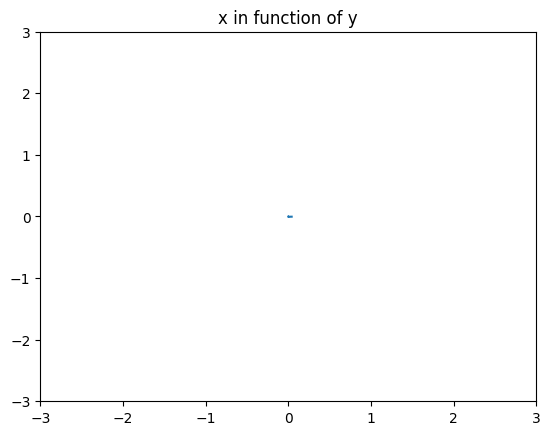

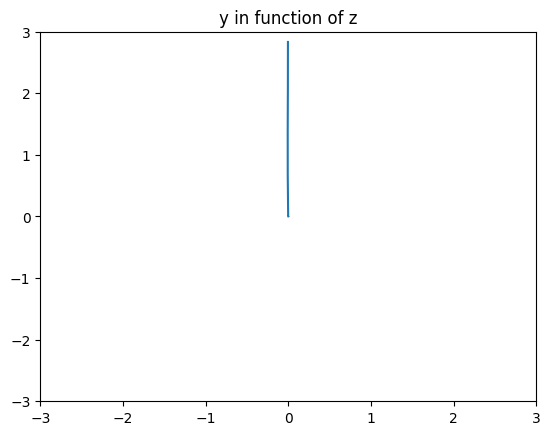

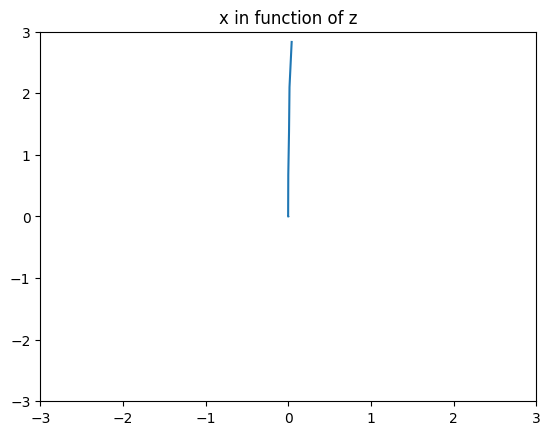

In [45]:
import matplotlib.pyplot as plt


def get_transformation_matrix(rvec, tvec):
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = tvec.flatten()
    return transformation_matrix


transformation_matrix = np.zeros((4, 4, 6))

for i in range(tvec_list.shape[0]):
    if i == 0:
        transformation_matrix[:, :, 0] = get_transformation_matrix(tvec_list[i, 3:], tvec_list[i, :3])
    else:
        transformation_matrix[:, :, i] = transformation_matrix[:, :, 0] + get_transformation_matrix(tvec_list[i, 3:],
                                                                                                    tvec_list[i, :3])

plt.plot(transformation_matrix[0, 3, :], transformation_matrix[1, 3, :], )
plt.title("x in function of y")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

plt.plot(transformation_matrix[1, 3, :], transformation_matrix[2, 3, :], )
plt.title("y in function of z")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

plt.plot(transformation_matrix[0, 3, :], transformation_matrix[2, 3, :], )
plt.title("x in function of z")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()